The Schwarzschild metric may be obtained by setting a = 0 in the Kerr metric. We shall also take $m=1$ and work in the equatorial plane $\sin\theta = 1$ or $\theta = \pi/2$. The metric has components
\begin{equation}
    g_{tt} = 1 - \frac{2}{r}, \quad g_{\phi\phi} = -r^2, \quad g_{rr} = \frac{r}{2-r}, \quad g_{\theta\theta} = -r^2.
\end{equation}
The effective potential is given by
\begin{equation}
    V_{\text{eff}}(r) = -\kappa + \frac{g_{\phi\phi}E^2 + 2g_{t\phi}EL_z + g_{tt}L_z^2}{g_{tt}g_{\phi\phi} - g_{t\phi}^2} = -\kappa + \frac{rE^2}{r - 2} - \frac{L_z^2}{r^2}.
\end{equation}
Motion is only possible when $V_{\text{eff}} \leq 0$.

In [137]:
import sympy
from sympy import symbols, sin, cos, Matrix
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def setup_numerical_kerr_functions(m_val, a_val):
    '''
    A compact function to perform symbolic setup and return numerical functions.
    '''
    t, r, th, ph, m, a = symbols('t r th ph m a')
    Sigma = r**2 + a**2*cos(th)**2
    Delta = r**2 - 2*m*r + a**2
    A = (r**2 + a**2)**2 - a**2*Delta*sin(th)**2
    g_ll = Matrix([
        [1 - 2*m*r/Sigma, 0, 0, 2*a*m*r*sin(th)**2/Sigma],
        [0, -Sigma/Delta, 0, 0],
        [0, 0, -Sigma, 0],
        [2*a*m*r*sin(th)**2/Sigma, 0, 0, -A/Sigma*sin(th)**2]
    ])

    # Substitute numerical values
    g_ll_num = g_ll.subs({m: m_val, a: a_val})

    # Lambdify g_ll
    g_funcs = np.empty((4, 4), dtype=object)
    for i in range(4):
        for j in range(4):
            expr = g_ll_num[i,j]
            g_funcs[i,j] = sympy.lambdify([r, th], expr, 'numpy') if expr != 0 else lambda r, th: 0

    # Calculate and Lambdify Gamma_ull
    g_uu_num = g_ll_num.inv()
    dg_matrices = [g_ll_num.diff(coord) for coord in [t, r, th, ph]]
    Gamma_funcs = np.empty((4, 4, 4), dtype=object)
    for i in range(4):
        for j in range(4):
            for k in range(4):
                raw_sum = sum(g_uu_num[i, m_idx] * (dg_matrices[k][j, m_idx] + dg_matrices[j][k, m_idx] - dg_matrices[m_idx][j, k]) for m_idx in range(4))
                expr = 0.5 * raw_sum
                Gamma_funcs[i, j, k] = sympy.lambdify([r, th], expr, 'numpy') if expr != 0 else lambda r, th: 0

    return g_funcs, Gamma_funcs

def kerr_geodesic_odes(tau, y, Gamma_funcs):
    '''
    The ODE system function.
    '''
    _, r_val, theta_val, _, u_t, u_r, u_theta, u_phi = y
    four_velocity = np.array([u_t, u_r, u_theta, u_phi])
    dydtau = np.zeros(8)
    dydtau[:4] = four_velocity
    for i in range(4):
        accel_sum = -sum(Gamma_funcs[i, j, k](r_val, theta_val) * four_velocity[j] * four_velocity[k] for j in range(4) for k in range(4))
        dydtau[i + 4] = accel_sum
    return dydtau

def integrate_geodesic(y0, tau_span, Gamma_funcs, events=None):
    '''
    The integrator function.
    '''
    ode_func = lambda tau, y: kerr_geodesic_odes(tau, y, Gamma_funcs)
    sol = solve_ivp(
        fun=ode_func, t_span=tau_span, y0=y0,
        method='DOP853', rtol=1e-11, atol=1e-11,
        events=events
    )
    return sol

In [138]:
def plot_coordinates(sol):
    '''
    Plots t, r, theta, phi as a function of proper time tau.
    '''
    tau = sol.t
    t, r, theta, phi = sol.y[0], sol.y[1], sol.y[2], sol.y[3]

    fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
    fig.suptitle('Particle Coordinates vs. Proper Time (τ)')

    axs[0, 0].plot(tau, t)
    axs[0, 0].set_ylabel('Time Coordinate (t)')
    axs[0, 0].set_title('t vs τ')

    axs[0, 1].plot(tau, r)
    axs[0, 1].set_ylabel('Radial Coordinate (r/M)')
    axs[0, 1].set_title('r vs τ')

    axs[1, 0].plot(tau, theta)
    axs[1, 0].set_ylabel('Polar Angle (θ)')
    axs[1, 0].set_xlabel('Proper Time (τ)')
    axs[1, 0].set_title('θ vs τ')

    axs[1, 1].plot(tau, phi)
    axs[1, 1].set_ylabel('Azimuthal Angle (φ)')
    axs[1, 1].set_xlabel('Proper Time (τ)')
    axs[1, 1].set_title('φ vs τ')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def check_conservation_laws(sol, g_funcs, E0, Lz0):
    '''
    Checks conservation of E, Lz, and the mass-shell condition.
    '''
    r, th = sol.y[1], sol.y[2]
    ut, ur, uth, uph = sol.y[4], sol.y[5], sol.y[6], sol.y[7]

    # Calculate metric components along trajectory
    gtt = g_funcs[0, 0](r, th)
    grr = g_funcs[1, 1](r, th)
    gthth = g_funcs[2, 2](r, th)
    gphph = g_funcs[3, 3](r, th)

    # Energy
    E_sol = gtt * ut
    E_err = np.abs((E_sol - E0) / E0)

    # Angular Momentum
    Lz_sol = -gphph * uph
    Lz_err = np.abs((Lz_sol - Lz0) / Lz0)

    # Mass-shell condition (kappa = g_ij u^i u^j should be constant)
    mass_shell = gtt*ut**2 + grr*ur**2 + gthth*uth**2 + gphph*uph**2
    mass_shell_err = np.abs(mass_shell)

    fig, axs = plt.subplots(1, 3, figsize=(18, 4))
    fig.suptitle('Check of Conservation Laws')
    axs[0].plot(sol.t, E_err, 'r'); axs[0].set_title('Energy (E) Error'); axs[0].set_yscale('log')
    axs[1].plot(sol.t, Lz_err, 'g'); axs[1].set_title('Angular Momentum (Lz) Error'); axs[1].set_yscale('log')
    axs[2].plot(sol.t, mass_shell_err, 'b'); axs[2].set_title('Mass-Shell (gμν u^μ u^ν = -1) Error'); axs[2].set_yscale('log')
    for ax in axs: ax.set_xlabel('Proper Time (τ)'); ax.set_ylabel('Absolute or Relative Error')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [139]:
def run_simulation(g_funcs, Gamma_funcs):
    '''
    Sets up and runs the simulation.
    '''
    E, Lz = 0.97, 4.0
    r0, theta0 = 15.0, np.pi / 2
    ur0 = 0.0 # As specified: dr/dtau = 0

    g_tt0 = g_funcs[0, 0](r0, theta0); g_phph0 = g_funcs[3, 3](r0, theta0)
    g_thth0 = g_funcs[2, 2](r0, theta0)

    # Calculate u_t and u_phi from the conserved quantities for Schwarzschild
    ut0 = E / g_tt0
    uphi0 = -Lz / g_phph0

    V_eff_0 = -1 + (E**2 / g_tt0) + (Lz**2 / g_phph0)
    utheta0_squared = -V_eff_0 / g_thth0
    utheta0 = np.sqrt(utheta0_squared)

    print(f"Initial velocity: ur0 = {ur0}, utheta0 = {utheta0:.6f}")
    y0 = np.array([0.0, r0, theta0, 0.0, ut0, ur0, utheta0, uphi0])

    solution = integrate_geodesic(y0, [0, 6000], Gamma_funcs)
    plot_coordinates(solution)
    check_conservation_laws(solution, g_funcs, E, Lz)


def run_poincare_simulation(g_funcs, Gamma_funcs, E, Lz, r0_values):
    '''
    Generates data for and plots a Poincaré map for a given E and Lz.
    '''
    poincare_points = []

    def equatorial_crossing(tau, y): return y[2] - np.pi / 2
    equatorial_crossing.direction = 1
    equatorial_crossing.terminal = False

    for r0 in r0_values:
        theta0 = np.pi/2
        ur0 = 0
        g_tt0 = g_funcs[0, 0](r0, theta0)
        g_phph0 = g_funcs[3, 3](r0, theta0)
        ut0 = E / g_tt0
        uphi0 = -Lz / g_phph0
        y0 = np.array([0., r0, theta0, 0., ut0, ur0, 0., uphi0])
        tau_span = [0, 4000]
        solution = integrate_geodesic(y0, tau_span, Gamma_funcs, events=equatorial_crossing)

        if solution.y_events[0].size > 0:
            for point in solution.y_events[0]:
                poincare_points.append((point[1], point[5]))

    if poincare_points:
        points = np.array(poincare_points)
        plt.figure(figsize=(6, 6)); plt.scatter(points[:, 0], points[:, 1], s=5, alpha=0.7)
        plt.title(f'Poincaré Map for E={E}, Lz={Lz}'); plt.xlabel('Radius (r/M)')
        plt.ylabel('Radial Velocity (dr/dτ)')
        plt.grid(True)
        plt.show()
    else:
        print("No equatorial crossings detected.")

Initial velocity: ur0 = 0.0, utheta0 = 0.008040


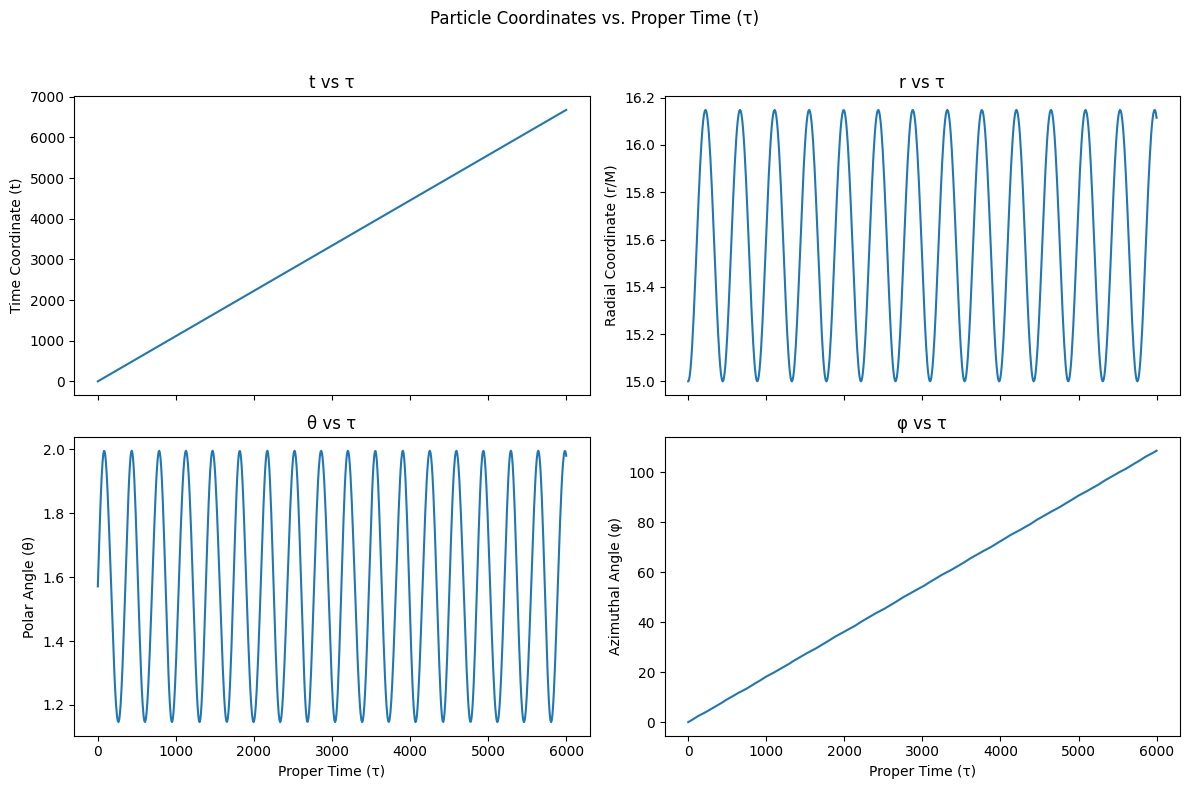

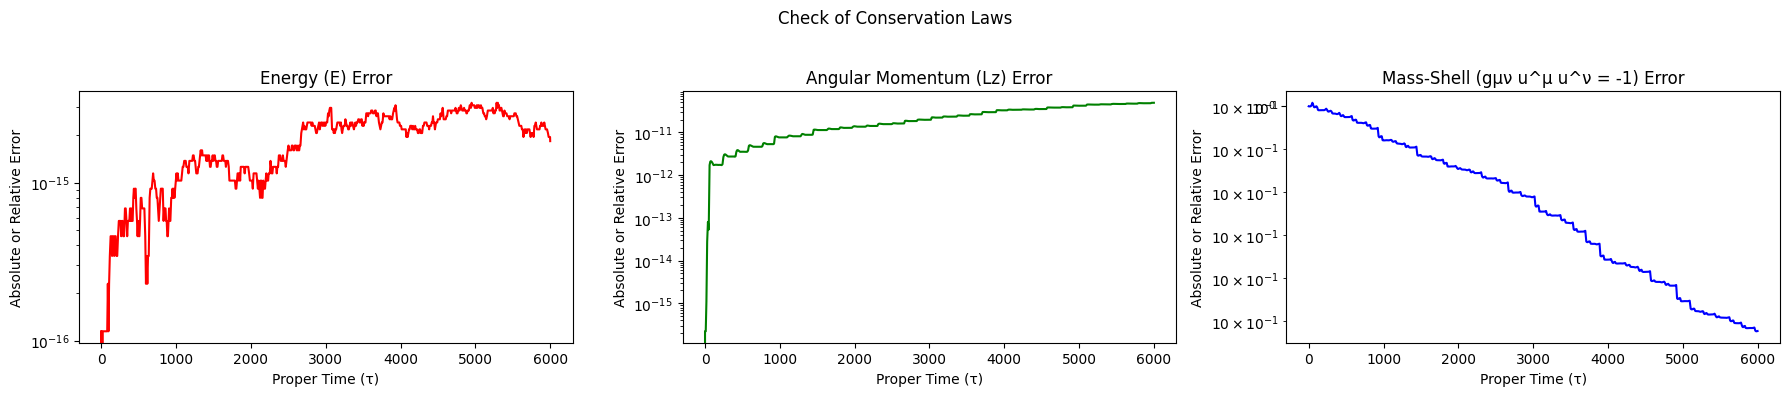

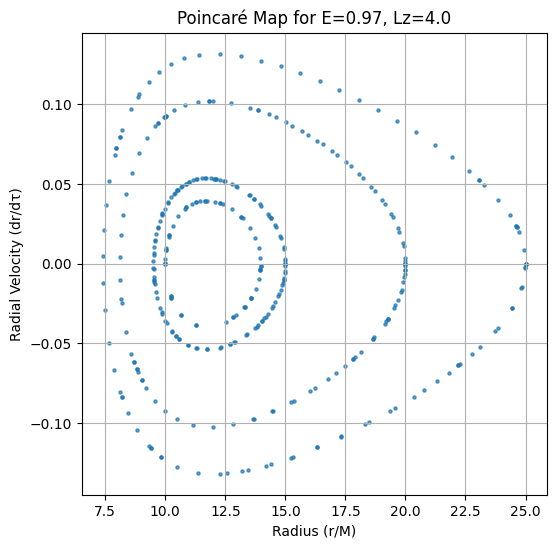

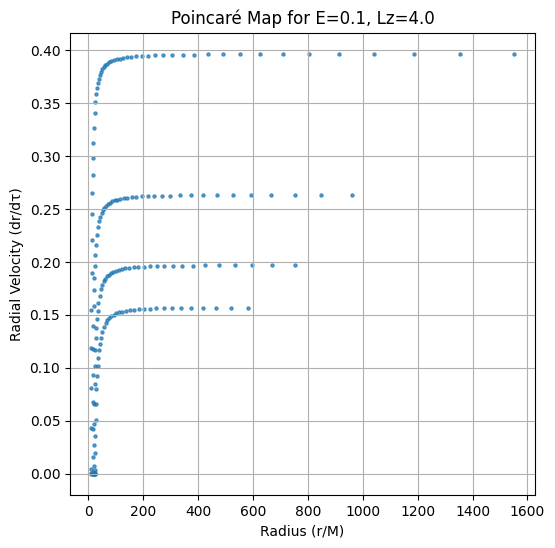

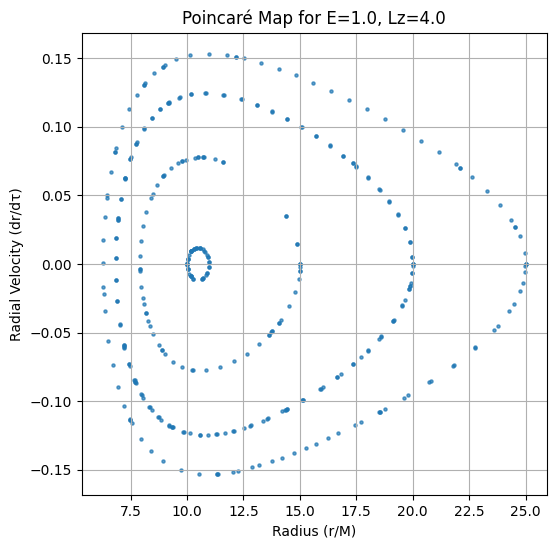

In [140]:
M_BH = 1.0
A_BH = 0.0 # Schwarzschild
g_funcs, Gamma_funcs = setup_numerical_kerr_functions(m_val=M_BH, a_val=A_BH)
run_simulation(g_funcs, Gamma_funcs)

# Allowed range is roughly [8.6, 23.9].
r_initial = [5.0 * i for i in range (2, 6)]
run_poincare_simulation(g_funcs, Gamma_funcs, E=0.97, Lz=4.0, r0_values=r_initial)
run_poincare_simulation(g_funcs, Gamma_funcs, E=0.1, Lz=4.0, r0_values=r_initial)
run_poincare_simulation(g_funcs, Gamma_funcs, E=1.0, Lz=4.0, r0_values=r_initial)